In [219]:
from numpy import log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from math import e
from pathlib import Path
import os

%matplotlib notebook

## apogee oxygen sensor
### thermistor

In [2]:
def r_apogee(vout, vex = 3.3):
    return 24900 * (vex/vout - 1)

def r_net(vout, vex = 3.3):
    return (vout * 24900) / (vex - vout)

In [3]:
r_apogee(1.07)

51894.39252336448

In [11]:
r_net(1.06)

11783.035714285716

In [7]:
def t(r):
    a = 1.129241e-3
    b = 2.341077e-4
    c = 8.775468e-8
    return 1 / (a + b * log(r) + c * log(r)**3) - 273.15

In [10]:
t(r_net(1.04))

21.924608766617325

In [12]:
r = r_net(1.06)
r

11783.035714285716

### oxygen sensor

In [48]:
def exp_decay(x, a, b, c):
    return a * np.exp(b * x) + c

In [207]:
sens = pd.read_clipboard(names=['rec', 'oxy1_adc', 'mV0_1', 'oxy2_adc', 'mV0_2', '6', '7', 'oxy1_temp', '9', '10', 'oxy2_temp'])
sens = sens.drop(columns = ['rec', 'oxy1_adc', 'oxy2_adc', '6', '7', '9', '10'])
# sens

In [208]:
# popt1, pcov1 = curve_fit(exp_decay, sens.index, sens['mV0_1'], p0 = [0.001, -0.005, 0.0015], bounds = ([0, -0.1, 0], [0.1, 0, .2]))
# popt2, pcov2 = curve_fit(exp_decay, sens.index, sens['mV0_2'], p0 = [0.001, -0.005, 0.0015], bounds = ([0, -0.1, 0], [0.1, 0, .2]))


<IPython.core.display.Javascript object>


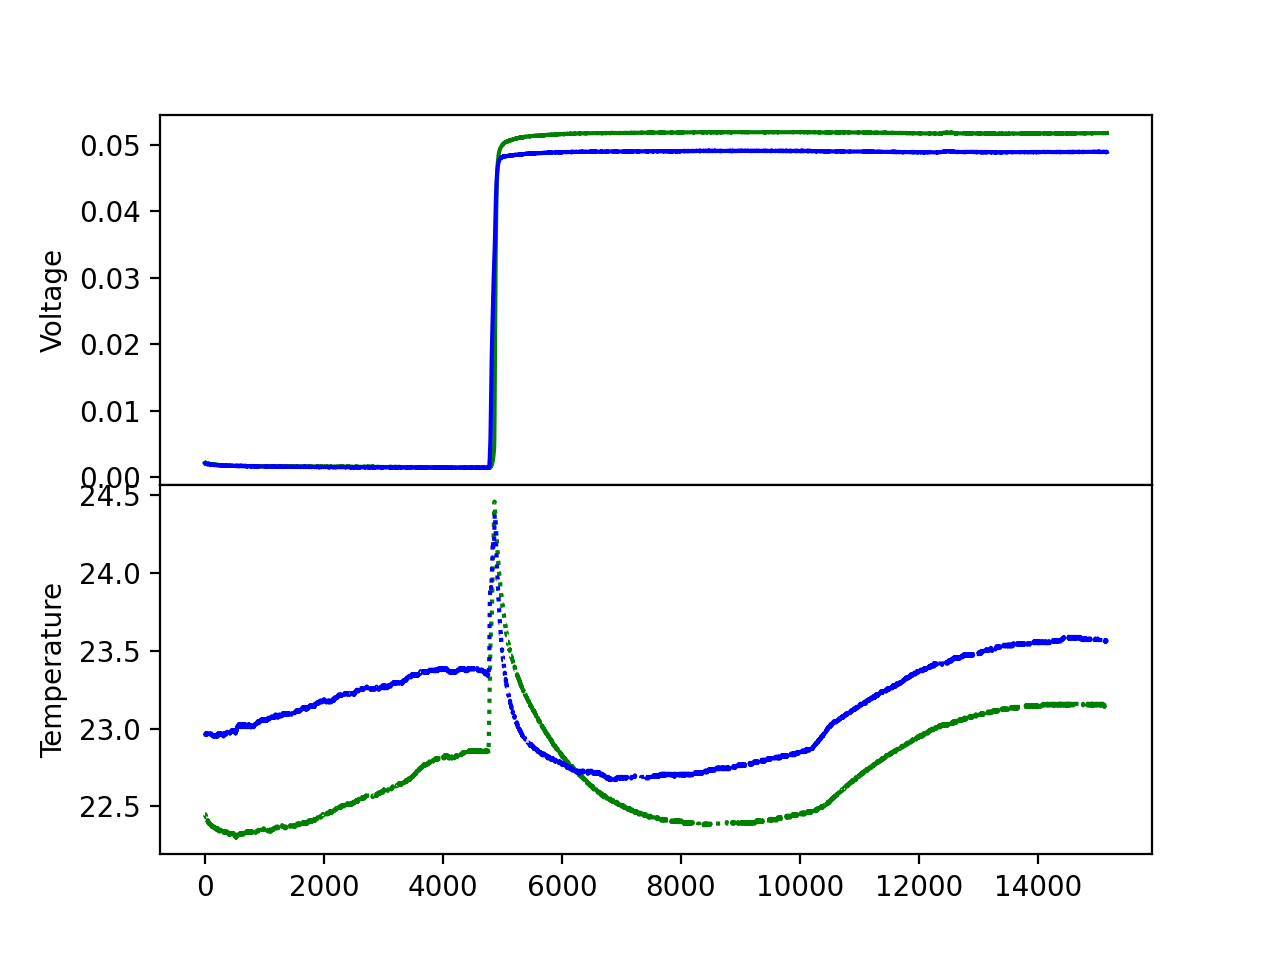

In [218]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Temperature')

# axs[0].set_ylim(0.0013, 0.0017)
# axs[0].set_ylim(0.047, 0.053)
# axs[0].set_xlim(4500, 7000)

axs[0].plot(sens.index, sens['mV0_1'], c='green')
axs[0].plot(sens.index, sens['mV0_2'], c='blue')
axs[1].plot(sens.index, sens['oxy1_temp'], c='green', ls='dotted')
axs[1].plot(sens.index, sens['oxy2_temp'], c='blue', ls='dotted')
# a1, b1, c1 = popt1
# axs[0].plot(sens.index, exp_decay(sens.index, a1, b1, c1), c='red')
# a2, b2, c2 = popt2
# axs[0].plot(sens.index, exp_decay(sens.index, a2, b2, c2), c='red')

find points at the same temperature in the 0% oxygen and ambient oxygen measurements

In [210]:
# oxy1 calibration: 22.5 C
oxy1_t_cal = 22.5
oxy1_V_0 = sens[(sens['oxy1_temp']==oxy1_t_cal) & (sens.index < 4740)]['mV0_1'].iloc[-1]
oxy1_V_cal = sens[(sens['oxy1_temp']==oxy1_t_cal) & (sens.index > 6000)]['mV0_1'].iloc[-1]
oxy1_V_0, oxy1_V_cal

(0.001562, 0.051875)

In [211]:
# oxy1 calibration: 23.0 C
oxy2_t_cal = 23.0
oxy2_V_0 = sens[(sens['oxy2_temp']==oxy2_t_cal) & (sens.index < 4740)]['mV0_1'].iloc[-1]
oxy2_V_cal = sens[(sens['oxy2_temp']==oxy2_t_cal) & (sens.index > 6000)]['mV0_1'].iloc[-1]
oxy2_V_0, oxy2_V_cal

(0.001719, 0.051859)

In [212]:
pressure_cal = 100.85
calibration = pd.DataFrame(
    {
        'Oxy1':[oxy1_V_cal, oxy1_V_0, oxy1_t_cal, pressure_cal],
        'Oxy2':[oxy2_V_cal, oxy2_V_0, oxy2_t_cal, pressure_cal],
    },
index = ['V_cal (V)', 'V_0 (V)', 'Temp (C)', 'Pressure (kPa)'])
calibration

,Oxy1,Oxy2
V_cal (V),0.051875,0.051859
V_0 (V),0.001562,0.001719
Temp (C),22.500000,23.000000
Pressure (kPa),100.850000,100.850000


In [213]:
path = Path(r'C:\Users\pcb74\Documents\lab\Arduino\reaction_monitor.calibration.csv')

In [214]:
sens.to_csv(path)

## McMillan Flow 100-3 and 100-5 flow meters

### flow meter calibration

In [232]:
#SN 46747
flow_100_3 = pd.DataFrame(
    {
        'flow':[20, 50, 100],
        'voltage':[0.90, 2.64, 4.90]
    }
)
#SN 47499
flow_100_5 = pd.DataFrame(
    {
        'flow':[100, 250, 500],
        'voltage':[0.90, 2.55, 5.05]
    }
)
cal_100_3 = linregress(flow_100_3['voltage'], flow_100_3['flow'])
cal_100_5 = linregress(flow_100_5['voltage'], flow_100_5['flow'])
print(f'100-3: Slope: {cal_100_3.slope}, Intercept: {cal_100_3.intercept}')
print(f'100-5: Slope: {cal_100_5.slope}, Intercept: {cal_100_5.intercept}')

100-3: Slope: 20.103417415227547, Intercept: 0.10905233849315721
100-5: Slope: 96.6787554876885, Intercept: 9.410192784882554


<IPython.core.display.Javascript object>


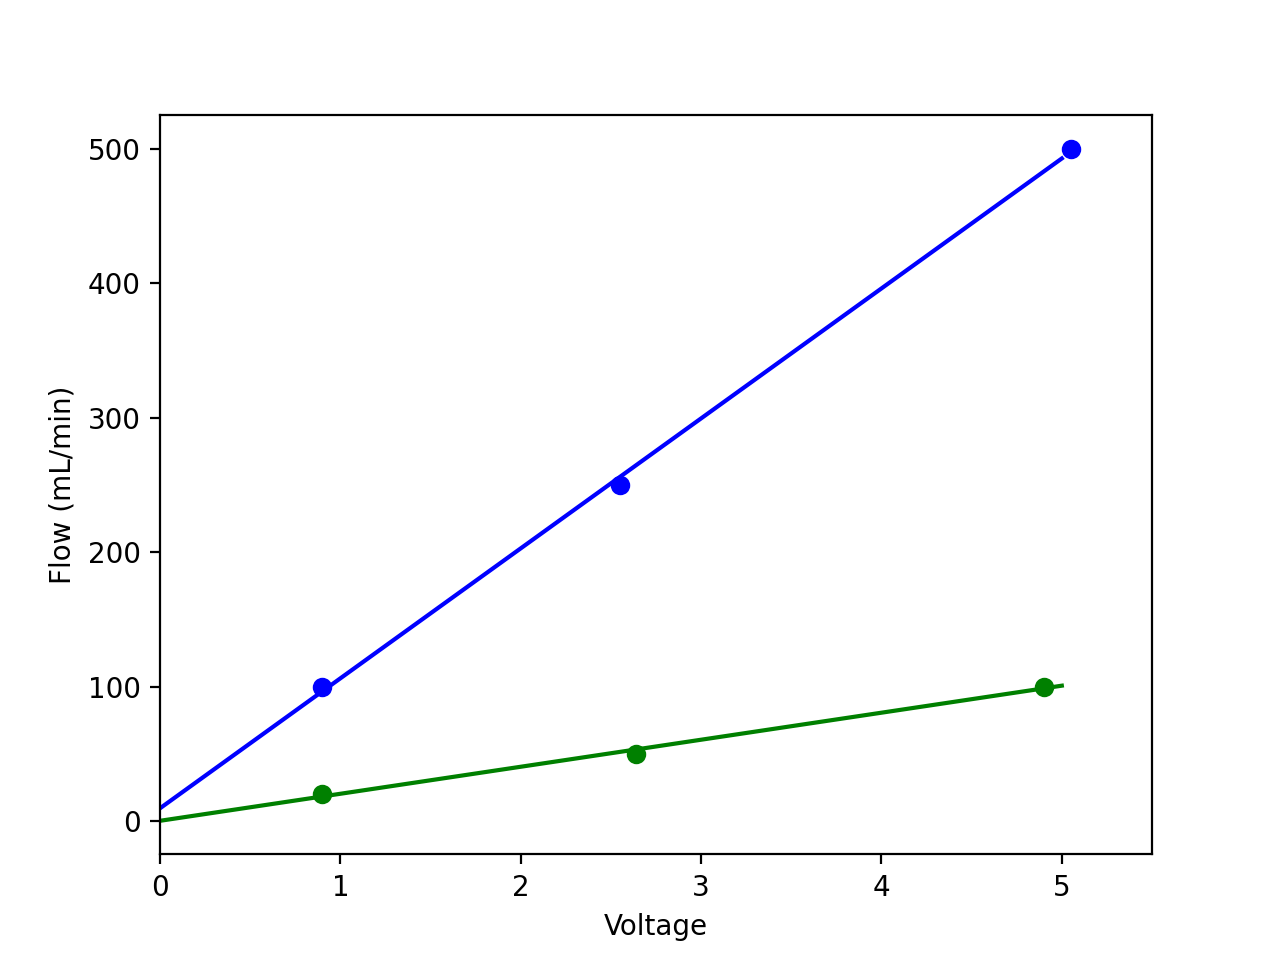

In [234]:
fig, ax = plt.subplots()
ax.set_xlabel('Voltage')
ax.set_ylabel('Flow (mL/min)')
# ax.set_ylim(0, 5.5)
ax.set_xlim(0, 5.5)
x3 = np.arange(0, 6)
x5 = np.arange(0, 6)
ax.scatter(flow_100_3['voltage'], flow_100_3['flow'], c='green')
ax.scatter(flow_100_5['voltage'], flow_100_5['flow'], c='blue')
def line(x, m, b):
    return m*x+b
ax.plot(x3, line(x3, cal_100_3.slope, cal_100_3.intercept), c='green')
ax.plot(x5, line(x5, cal_100_5.slope, cal_100_5.intercept), c='blue')